In [1]:
%load_ext autoreload
%autoreload complete

In [2]:
from src.data.protests import get_climate_protests
from src.models.instrumental_variables import (
    instrumental_variables,
    size_labels,
    size_pairs,
)

protests = get_climate_protests(groups=["fff", "alg", "xr", "eg"])
results = instrumental_variables(protests)

In [4]:
from linearmodels.iv import compare

compare(results, stars=True, precision="pvalues")
# for result in results.values():
#     print(result.summary)
#     print()

,climate_and_protest,climate_and_protest,climate_and_protest,climate_and_protest,climate_and_protest,climate_and_protest,climate_and_protest,climate_and_protest,climate_and_protest,climate_and_protest,climate_and_protest,climate_and_protest,climate_and_protest,climate_and_protest,climate_and_protest
,['size'] ~ weather_and_covid,['size'] ~ weather_and_covid,['size'] ~ weather_and_covid,['log10(size)'] ~ weather_and_covid,['log10(size)'] ~ weather_and_covid,['log10(size)'] ~ weather_and_covid,['sqrt(size)'] ~ weather_and_covid,['sqrt(size)'] ~ weather_and_covid,['sqrt(size)'] ~ weather_and_covid,"['size', 'log10(size)', 'sqrt(size)'] ~ weather_and_covid","['size', 'log10(size)', 'sqrt(size)'] ~ weather_and_covid","['size', 'log10(size)', 'sqrt(size)'] ~ weather_and_covid","['10<=size<100', '100<=size<1000', '1000<=size<10000'] ~ weather_and_covid","['10<=size<100', '100<=size<1000', '1000<=size<10000'] ~ weather_and_covid","['10<=size<100', '100<=size<1000', '1000<=size<10000'] ~ weather_and_covid"
,with exog,with exog,with exog,with exog,with exog,with exog,with exog,with exog,with exog,with exog,with exog,with exog,with exog,with exog,with exog
,1 days,1 days,1 days,1 days,1 days,1 days,1 days,1 days,1 days,1 days,1 days,1 days,1 days,1 days,1 days
,OLS,IV2SLS,IVGMM,OLS,IV2SLS,IVGMM,OLS,IV2SLS,IVGMM,OLS,IV2SLS,IVGMM,OLS,IV2SLS,IVGMM
Dep. Variable,discourse_change,discourse_change,discourse_change,discourse_change,discourse_change,discourse_change,discourse_change,discourse_change,discourse_change,discourse_change,discourse_change,discourse_change,discourse_change,discourse_change,discourse_change
Estimator,OLS,IV-2SLS,IV-GMM,OLS,IV-2SLS,IV-GMM,OLS,IV-2SLS,IV-GMM,OLS,IV-2SLS,IV-GMM,OLS,IV-2SLS,IV-GMM
No. Observations,327,327,327,327,327,327,327,327,327,327,327,327,327,327,327
Cov. Est.,robust,robust,robust,robust,robust,robust,robust,robust,robust,robust,robust,robust,robust,robust,robust
R-squared,0.3426,0.2409,0.1733,0.3202,0.3196,0.2839,0.3973,0.3776,0.3774,0.4002,0.2171,0.2366,0.2523,0.1182,0.1563
Adj. R-squared,0.3019,0.1940,0.1221,0.2781,0.2775,0.2396,0.3600,0.3391,0.3389,0.3589,0.1632,0.1840,0.2008,0.0575,0.0982


Statistical tests:

- "Rule of thumb": The F-statistic of the first stage should be >=10.

In [5]:
for i, k in enumerate(results.keys()):
    print(i, k.replace("\n", " "))

0 climate_and_protest ['size'] ~ weather_and_covid with exog 1 days OLS
1 climate_and_protest ['size'] ~ weather_and_covid with exog 1 days IV2SLS
2 climate_and_protest ['size'] ~ weather_and_covid with exog 1 days IVGMM
3 climate_and_protest ['log10(size)'] ~ weather_and_covid with exog 1 days OLS
4 climate_and_protest ['log10(size)'] ~ weather_and_covid with exog 1 days IV2SLS
5 climate_and_protest ['log10(size)'] ~ weather_and_covid with exog 1 days IVGMM
6 climate_and_protest ['sqrt(size)'] ~ weather_and_covid with exog 1 days OLS
7 climate_and_protest ['sqrt(size)'] ~ weather_and_covid with exog 1 days IV2SLS
8 climate_and_protest ['sqrt(size)'] ~ weather_and_covid with exog 1 days IVGMM
9 climate_and_protest ['size', 'log10(size)', 'sqrt(size)'] ~ weather_and_covid with exog 1 days OLS
10 climate_and_protest ['size', 'log10(size)', 'sqrt(size)'] ~ weather_and_covid with exog 1 days IV2SLS
11 climate_and_protest ['size', 'log10(size)', 'sqrt(size)'] ~ weather_and_covid with exog 1

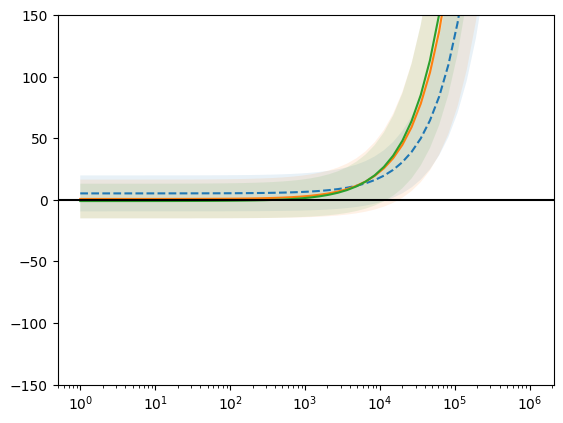

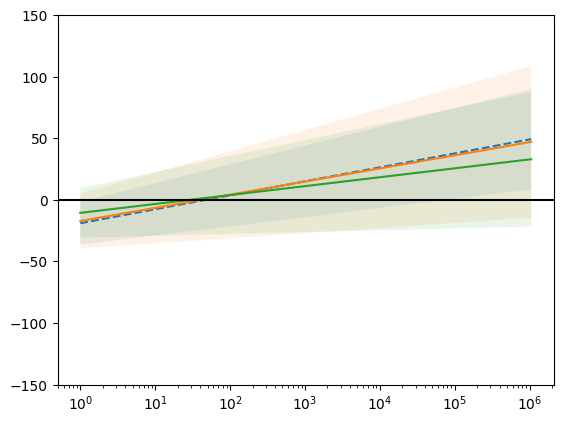

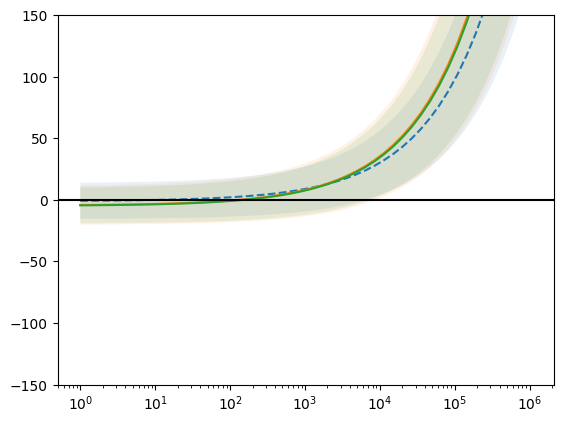

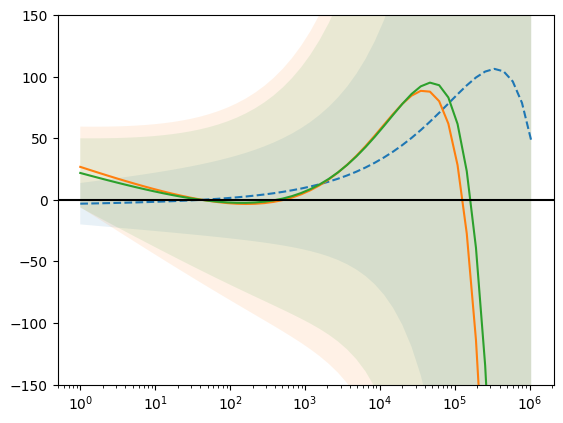

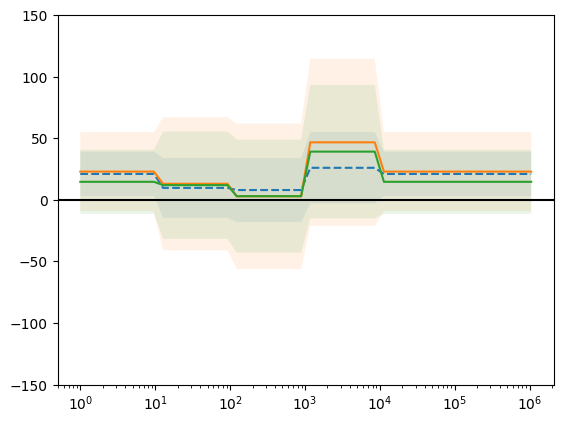

In [8]:
import numpy as np

# plot some of the models
from matplotlib import pyplot as plt


def get_y(result, X):
    y_size = 0
    if "size" in result.params:
        y_size += result.params["size"] * X
    if "log10(size)" in result.params:
        y_size += result.params["log10(size)"] * np.log10(X)
    if "sqrt(size)" in result.params:
        y_size += result.params["sqrt(size)"] * np.sqrt(X)
    for label, (m, n) in zip(size_labels, size_pairs):
        if f"{m}<=size<{n}" in result.params:
            y_size += result.params[f"{m}<=size<{n}"] * (X >= m) * (X < n)
    y = (
        result.params["const"]
        + result.params["admin1_Berlin"]
        + result.params["assoc_actor_1_FFF🌍"]
        + y_size
    )
    return y


def get_y_confint(result, X, lu):
    var = result.conf_int(0.9)
    get_var = lambda x: var.loc[x, lu]
    y_size = 0
    if "size" in var.index:
        y_size += get_var("size") * X
    if "log10(size)" in result.conf_int().index:
        y_size += get_var("log10(size)") * np.log10(X)
    if "sqrt(size)" in result.conf_int().index:
        y_size += get_var("sqrt(size)") * np.sqrt(X)
    for label, (m, n) in zip(size_labels, size_pairs):
        if f"{m}<=size<{n}" in result.conf_int().index:
            y_size += get_var(f"{m}<=size<{n}") * (X >= m) * (X < n)
    y = (
        get_var("const")
        + get_var("admin1_Berlin")
        + get_var("assoc_actor_1_FFF🌍")
        + y_size
    )
    return y


for i in [0, 3, 6, 9, 12]:
    X = np.linspace(0, 20)
    X = 2**X
    for j in [0, 1, 2]:
        name, result = list(results.items())[i + j]
        linestyle = ["--", "-", "-"][j]
        plt.plot(X, get_y(result, X), label=name, linestyle=linestyle)
        plt.fill_between(
            X,
            get_y_confint(result, X, "lower"),
            get_y_confint(result, X, "upper"),
            alpha=0.1,
        )
    plt.semilogx()
    plt.ylim(-150, 150)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.axhline(0, color="black")
    plt.show()


# for i in [0, 1, 2]:
#     name, result = list(results.items())[i]
#     X = np.linspace(0, 100_000, 10_000)
#     for j in [0, 3, 6, 9]:
#         name, result = list(results.items())[i + j]
#         plt.plot(X, get_y(result, X), label=name, linestyle="-")
#         plt.fill_between(
#             X,
#             get_y_confint(result, X, "lower"),
#             get_y_confint(result, X, "upper"),
#             alpha=0.1,
#         )
#     # plt.semilogx()
#     plt.ylim(-150, 150)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
#     plt.show()

lol.